In [71]:
using ITensors
using Plots
using JLD2
using Plots.PlotMeasures
using Base.Threads
using ITensorMPS
using ProgressMeter
include("../../LogLoss/RealRealHighDimension.jl")
include("../../Interpolation/imputation.jl");

In [6]:
mps_80_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ipd_d12_chi80v2.jld2");
mps_80 = read(mps_80_f, "mps")
mps_80_opts = read(mps_80_f, "opts")
mps_80_Xtrain = read(mps_80_f, "X_train")
mps_80_Xtest = read(mps_80_f, "X_test")
close(mps_80_f)

X_train, norms = transform_train_data(mps_80_Xtrain; opts=mps_80_opts);
X_test, _ = transform_test_data(mps_80_Xtest, norms; opts=mps_80_opts);

┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.07770515908031447
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253
┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.09112157823813859
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253


5 rescaling operations were performed!


┌ Warning: Test set has a value more than 1% above upper bound after train normalization! ub=1.1967932908732675
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:263
┌ Warning: Test set has a value more than 1% above upper bound after train normalization! ub=1.0561060075720665
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:263
┌ Warning: Test set has a value more than 1% above upper bound after train normalization! ub=1.0289034091057059
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:263


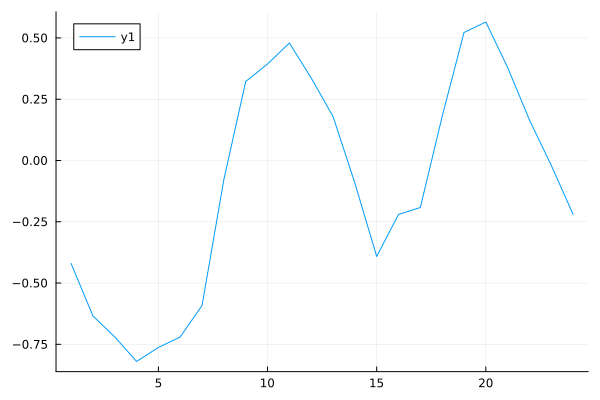

In [14]:
plot(X_train[1, :])

In [ ]:
function entropy_von_neumann_see(mps::MPS)
    # compute single-site entanglement entropy
    psi = deepcopy(mps)
    psi_length = length(psi)
    entropy_vals = zeros(psi_length)
    for oc in eachindex(psi)
        orthogonalize!(psi, oc)
        S = 0
        if oc == 1 || oc == psi_length
            _, S, _ = svd(psi[oc], (siteind(psi, oc)))
        else
            _, S, _ = svd(psi[oc], (linkind(psi, oc-1), siteind(psi, oc)))
        end
        normalize!(S)
        SvN = 0.0
        # loop over the diagonal of the singular value matrix and extract the values
        for n = 1:ITensors.dim(S, 1)
            p = S[n, n]^2
            if (p > 1E-12) # to avoid log(0)
                SvN += -p * log(p) # natural logarithm
            end
        end
        entropy_vals[oc] = SvN
    end
    return entropy_vals
end

entropy_von_neumann_see (generic function with 1 method)

In [4]:
ipd_before_measurement = entropy_von_neumann_see(mps_80);

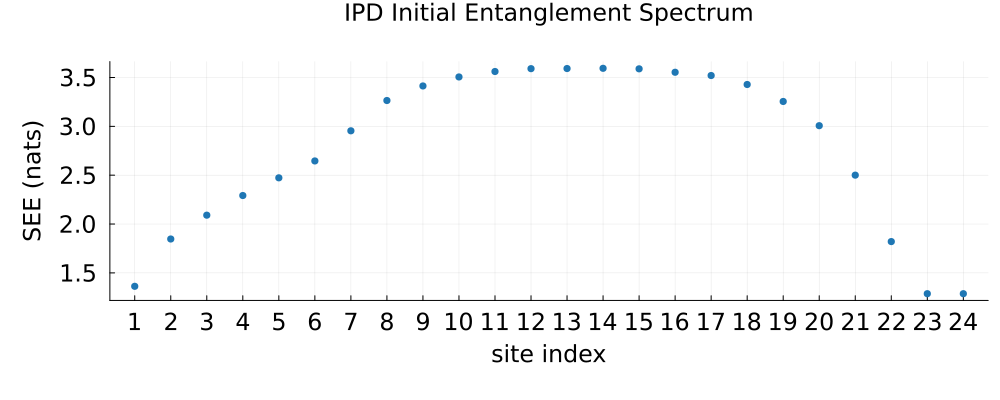

In [5]:
fstyle = font("sans-serif", 16)
scatter(ipd_before_measurement, ms=4, label="", msw=0, xticks=collect(1:1:24),
    xlabel="site index", ylabel="SEE (nats)", c=palette(:tab10)[1], title="IPD Initial Entanglement Spectrum",
    titlefont=fstyle, xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle,
    size=(1000, 400), left_margin=10mm, bottom_margin=15mm, top_margin=10mm)
#savefig("ipd_entanglement_spectrum_before_measurement.svg")

In [3]:
function measure_mps(mps::MPS, opts, xval::Float64, site::Int)
    # check xval in range
    if !(-1 ≤ xval ≤ 1)
        error("x value must be in encoding domain [-1, 1]")
    end
    # check site exists in mps
    if !(1 ≤ site ≤ length(mps))
        error("Site must exist in the MPS")
    end
    psi = deepcopy(mps)
    total_num_sites = length(psi)
    s = siteinds(psi)
    known_state_as_ITensor = itensor(get_state(xval, opts), s[site])
    site_loc = findsite(psi, s[site])
    A = psi[site_loc] # extract the site to measure from the MPS 
    Am = A * dag(known_state_as_ITensor)
    if site_loc == total_num_sites
        A_new = psi[(site_loc-1)] * Am # absorb into previous site
    else
        A_new = psi[(site_loc+1)] * Am
    end
    
    normalize!(A_new)
    psi[site_loc] = ITensor(1) # replace old site with Identity
    if site_loc == total_num_sites
        psi[site_loc-1] = A_new
    else
        psi[site_loc + 1] = A_new
    end
    # collapse the MPS to the remaining unmeasured sites
    mps_el = [tens for tens in psi if ndims(tens) > 0]
    mps_measured = MPS(mps_el)
    normalize!(mps_measured)
    return mps_measured
end

measure_mps (generic function with 1 method)

In [4]:
function measure_mps_with_ts_sample(mps::MPS, ts::Vector{<:Real}, opts::Options, measure_sites::Vector)
    # measure the mps with values from an actual (normalised) time series
    # check that the time series is in the encoding domain
    if !all(-1 .≤ ts .≤ 1)
        error("Time series must be normalised to the interval [-1, 1].")
    end
    psi = deepcopy(mps)
    total_num_sites = length(psi) 
    sites = siteinds(psi)
    encoded_ts = MPS([ITensor(opts.encoding.encode(ts[i], opts.d), sites[i]) for i in 1:length(ts)]) # encode all values, only use measure_sites
    # loop through mps and measure sites of interest
    last_impute_idx = 0
    for i in 1:total_num_sites
        if i in measure_sites
            site_loc = findsite(psi, sites[i]) # get the site of interest
            A = psi[site_loc] # extract the site to measure from the MPS 
            known_state_as_ITensor = encoded_ts[i]
            Am = A * dag(known_state_as_ITensor)
            if site_loc == total_num_sites
                A_new = psi[last_impute_idx] * Am # will IndexError if there are no sites to impute
            else
                A_new = psi[(site_loc+1)] * Am
            end
            normalize!(A_new)
            psi[site_loc] = ITensor(1)
            if site_loc == total_num_sites
                psi[last_impute_idx] = A_new 
            else
                psi[site_loc + 1] = A_new
            end
            println("Measured site $i")
        else
            last_impute_idx = i
        end
    end
    # collapse the MPS to the remaining unmeasured sites
    mps_el = [tens for tens in psi if ndims(tens) > 0]
    mps_measured = MPS(mps_el)
    normalize!(mps_measured)

    return mps_measured
end

measure_mps_with_ts_sample (generic function with 1 method)

In [8]:
# measure first 2 sites
ee_before = entropy_von_neumann_see(mps_80);
measured_mps = measure_mps_with_ts_sample(mps_80, X_test[2, :], mps_80_opts, [24]);
ee_after = entropy_von_neumann_see(measured_mps);

Measured site 24


In [9]:
sum(ee_after - ee_before[1:23])/23

-0.3289716111906877

In [185]:
function create_colormap(values::Vector{Float64}, color_start::Colorant=colorant"red", color_end::Colorant=colorant"white")
    # Normalize the values to the range [0, 1]
    min_val = -maximum(abs.((values)))
    max_val = maximum(abs.((values)))
    norm_values = (values .- min_val) ./ (max_val - min_val) 

    # Create a colormap by interpolating between the start and end colors
    colormap = [color_start * (1 - v) + color_end * v for v in norm_values]


    return colormap
end

create_colormap (generic function with 3 methods)

In [186]:
# loop over each site in ts and get the ⟨δS⟩
avg_ee_variation = zeros(24)
samp_idx = 123
ee_before = entropy_von_neumann_see(mps_80)
for i in 1:24
    measured_mps = measure_mps_with_ts_sample(mps_80, X_test[samp_idx, :], mps_80_opts, [i]);
    ee_after = entropy_von_neumann_see(measured_mps);
    ee_before_excluded = [ee_before[j] for j=1:24 if j !== i] # exclude measured site
    sum_diff = sum(ee_after - ee_before_excluded)
    avg_variation = sum_diff/length(ee_after)
    avg_ee_variation[i] = avg_variation
end
cmap = create_colormap(avg_ee_variation)

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


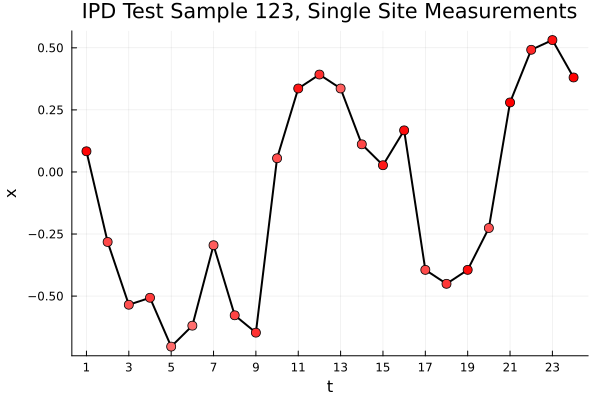

In [187]:
plot(X_test[samp_idx, :], label="", lw=2, c=:black, xlabel="t",
    ylabel="x", title="IPD Test Sample $samp_idx, Single Site Measurements", xticks=collect(1:2:24))
scatter!(X_test[samp_idx, :], label="", c=cmap, ms=5, msw=1)
#savefig("ipd_samp654_deltaS.svg")

In [197]:
ee_before = entropy_von_neumann_see(mps_80)
measure_site = 4
measured_mps = measure_mps_with_ts_sample(mps_80, X_test[123, :], mps_80_opts, [measure_site]);
ee_after = entropy_von_neumann_see(measured_mps);
ee_before_excluded = [ee_before[j] for j=1:24 if j !== measure_site]

Measured site 4


23-element Vector{Float64}:
 1.3625773208823049
 1.8467787573598644
 2.090662863409509
 2.4730143762913293
 2.645764110238529
 2.9543543654547686
 3.2644265323235544
 3.413394956264718
 3.5055970919222106
 3.5612866810942463
 ⋮
 3.553552947405086
 3.5201865190235155
 3.428359858105458
 3.254613578876121
 3.0067607422410147
 2.5004411453219824
 1.8203376809446414
 1.2869015436906337
 1.2869015436906337

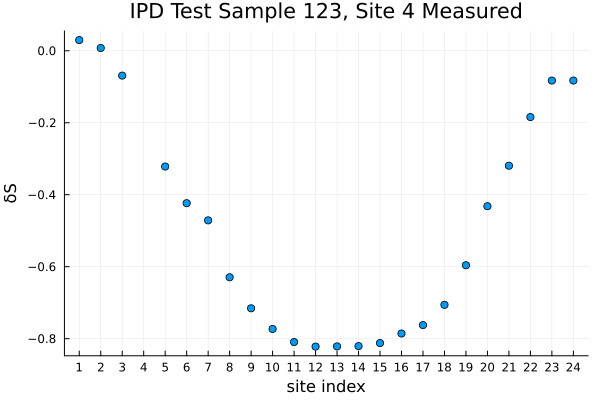

In [198]:
diffs = (ee_after - ee_before_excluded)
scatter(vcat(collect(1:(measure_site-1)), collect((measure_site+1):24)), diffs, xticks=(1:1:24), xlabel="site index", 
    ylabel="δS", label="", title="IPD Test Sample 123, Site $measure_site Measured")

In [180]:
ee_change_mat = zeros(24, 24)
sample_idx = 123
ee_before = entropy_von_neumann_see(mps_80)
for i in 1:24
    measured_mps = measure_mps_with_ts_sample(mps_80, X_test[sample_idx, :], mps_80_opts, [i]);
    ee_after = entropy_von_neumann_see(measured_mps);
    ee_before_excluded = [ee_before[j] for j=1:24 if j !== i]
    diffs = (ee_after - ee_before_excluded)
    write_idxs = vcat(collect(1:i-1), collect(i+1:24))
    ee_change_mat[i, write_idxs] = diffs
end

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


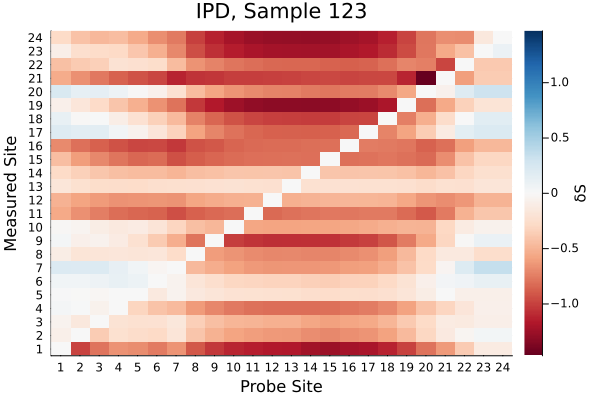

In [181]:
max_abs_val = maximum(abs.(ee_change_mat))
heatmap(ee_change_mat, xticks=1:24, yticks=1:24, 
    ylabel="Measured Site", xlabel="Probe Site", colorbar_title="δS",
    title="IPD, Sample $sample_idx", c=:RdBu, clims=(-max_abs_val, max_abs_val))
#savefig("ipd_sample100_deltaS_probe.svg")

In [220]:
ee_before = entropy_von_neumann_see(mps_80)
sum_before = sum(ee_before)
#sequential_ee_avg_variation = zeros(23)
measure_sites = []
sample_idx = 9
sums_seq_measure = zeros(23)
for i in 1:23
    push!(measure_sites, i) # add next site to measure
    println("Measuring sites: $measure_sites")
    ee_after = entropy_von_neumann_see(measure_mps_with_ts_sample(mps_80, X_test[sample_idx, :], mps_80_opts, measure_sites))
    #ee_before_excluded = [ee_before[j] for j=1:24 if j ∉ measure_sites]
    #sum_ee_before = sum(ee_before_excluded)
    sum_ee_after = sum(ee_after)
    #diff_sum = sum_ee_after - sum_ee_before
    #diffs = ee_after - ee_before_excluded
    #sum_diffs = sum(diffs)
    #avg_variation = sum_diffs/length(ee_after)
    #sequential_ee_avg_variation[i] = diff_sum
    sums_seq_measure[i] = sum_ee_after
end


Measuring sites: Any[1]
Measured site 1
Measuring sites: Any[1, 2]
Measured site 1
Measured site 2
Measuring sites: Any[1, 2, 3]
Measured site 1
Measured site 2
Measured site 3
Measuring sites: Any[1, 2, 3, 4]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measuring sites: Any[1, 2, 3, 4, 5]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measuring sites: Any[1, 2, 3, 4, 5, 6]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Meas

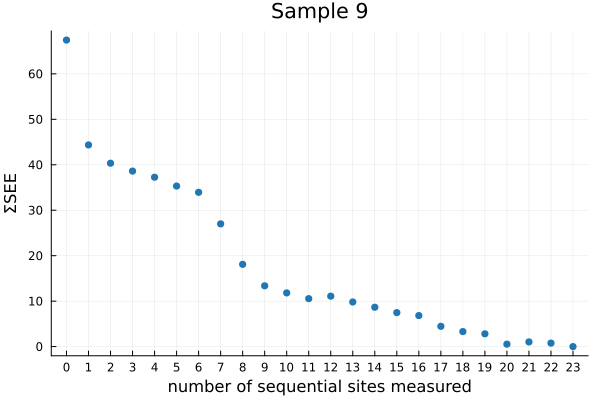

In [221]:
scatter(collect(0:23), vcat(sum_before,sums_seq_measure), label="", xlabel="number of sequential sites measured", 
    xticks=0:23, ylabel="ΣSEE", title="Sample $sample_idx", ms=4, msw=0,
    c=palette(:tab10)[1])

In [6]:
function see_variation_instances(mps::MPS, ts_mat::Matrix, opts::Options)
    # compute the SEE variations for multiple samples
    # useful for the purposes of clustering, etc.
    psi = deepcopy(mps)
    num_instances = size(ts_mat, 1)
    ee_change_mat = zeros(size(ts_mat)) # store results for each ts instance 
    ee_before = entropy_von_neumann_see(psi)
    # loop over time series instances
    for instance in 1:num_instances
        # loop over sites
        ee_chang_per_site = zeros(size(ts_mat, 2))
        for site in 1:(size(ts_mat, 2))
            measured_mps = measure_mps_with_ts_sample(psi, ts_mat[instance, :], opts, [site]);
            ee_after = entropy_von_neumann_see(measured_mps);
            ee_before_excluded = [ee_before[j] for j=1:size(ts_mat, 2) if j !== site]
            sum_diffs = sum(ee_after - ee_before_excluded)
            avg_variation = sum_diffs/length(ee_after)
            ee_chang_per_site[site] = avg_variation
        end
        ee_change_mat[instance, :] = ee_chang_per_site
    end
    return ee_change_mat
end

see_variation_instances (generic function with 1 method)

In [12]:
all_train_instances_sees = see_variation_instances(mps_80, X_train, mps_80_opts);

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:   3%|█▎                                       |  ETA: 0:05:20

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:   4%|█▉                                       |  ETA: 0:05:13

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:   6%|██▌                                      |  ETA: 0:05:07

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:   7%|███                                      |  ETA: 0:05:09

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:   9%|███▋                                     |  ETA: 0:05:05

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  10%|████▎                                    |  ETA: 0:05:00

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  12%|████▉                                    |  ETA: 0:04:56

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  13%|█████▌                                   |  ETA: 0:04:53

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  15%|██████▏                                  |  ETA: 0:04:49

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  16%|██████▊                                  |  ETA: 0:04:43

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  18%|███████▍                                 |  ETA: 0:04:36

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  19%|████████                                 |  ETA: 0:04:29

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  21%|████████▋                                |  ETA: 0:04:23

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  22%|█████████▏                               |  ETA: 0:04:18

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  24%|█████████▊                               |  ETA: 0:04:12

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  25%|██████████▍                              |  ETA: 0:04:07

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  27%|███████████                              |  ETA: 0:04:03

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  28%|███████████▋                             |  ETA: 0:03:57

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  30%|████████████▎                            |  ETA: 0:03:51

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  31%|████████████▉                            |  ETA: 0:03:44

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  33%|█████████████▌                           |  ETA: 0:03:38

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  34%|██████████████▏                          |  ETA: 0:03:32

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  36%|██████████████▋                          |  ETA: 0:03:26

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  37%|███████████████▎                         |  ETA: 0:03:20

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  39%|███████████████▉                         |  ETA: 0:03:14

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  40%|████████████████▌                        |  ETA: 0:03:09

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  42%|█████████████████▏                       |  ETA: 0:03:03

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  43%|█████████████████▊                       |  ETA: 0:02:57

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  45%|██████████████████▍                      |  ETA: 0:02:52

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  46%|███████████████████                      |  ETA: 0:02:47

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  48%|███████████████████▋                     |  ETA: 0:02:42

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  49%|████████████████████▎                    |  ETA: 0:02:37

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  51%|████████████████████▊                    |  ETA: 0:02:33

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  52%|█████████████████████▍                   |  ETA: 0:02:28

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  54%|██████████████████████                   |  ETA: 0:02:24

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  55%|██████████████████████▋                  |  ETA: 0:02:20

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  57%|███████████████████████▎                 |  ETA: 0:02:16

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  58%|███████████████████████▉                 |  ETA: 0:02:11

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  60%|████████████████████████▌                |  ETA: 0:02:06

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  61%|█████████████████████████▏               |  ETA: 0:02:02

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  63%|█████████████████████████▊               |  ETA: 0:01:57

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  64%|██████████████████████████▍              |  ETA: 0:01:52

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  66%|██████████████████████████▉              |  ETA: 0:01:48

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  67%|███████████████████████████▌             |  ETA: 0:01:43

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  69%|████████████████████████████▏            |  ETA: 0:01:38

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  70%|████████████████████████████▊            |  ETA: 0:01:33

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  72%|█████████████████████████████▍           |  ETA: 0:01:28

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  73%|██████████████████████████████           |  ETA: 0:01:24

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  75%|██████████████████████████████▋          |  ETA: 0:01:19

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  76%|███████████████████████████████▎         |  ETA: 0:01:14

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  78%|███████████████████████████████▉         |  ETA: 0:01:09

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:05

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  81%|█████████████████████████████████        |  ETA: 0:01:00

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:55

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:50

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:46

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:41

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:36

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:32

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:27

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:23

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:18

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:14

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:09

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:05

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Measured site 24


Progress: 100%|█████████████████████████████████████████| Time: 0:05:03


In [16]:
xvals = -1:0.01:1
mean_variations = zeros(length(xvals));
ipd_before_measurement = entropy_von_neumann_see(mps_80);
ee_before = sum(ipd_before_measurement) - ipd_before_measurement[2] # remove contribution from measured site 
site_loc = 2
for (i, x) in enumerate(xvals)
    println("$i")
    measured_mps = measure_mps(mps_80, mps_80_opts, x, site_loc);
    see_measured_allsites = entropy_von_neumann_see(measured_mps);
    ee_after = sum(see_measured_allsites)
    sum_ee_variation = ee_after - ee_before
    ee_avg_variation = sum_ee_variation/length(measured_mps)
    mean_variations[i] = ee_avg_variation
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201


Loop over sites:

In [ ]:
xvals = -1:0.005:1
ee_before = sum(ipd_before_measurement) - ipd_before_measurement[2] # remove contribution from measured site 
mean_var_matrix = zeros(length(xvals), length(mps))
sites = 1:24
for s in sites
    println("Evaluating site $s")
    sitewise_per_x_variations = zeros(length(xvals))
    time_taken = @elapsed begin
        for i in 1:length(xvals)
            measured_mps = measure_mps(mps, opts, xvals[i], s);
            see_measured_allsites = entropy_von_neumann_see(measured_mps);
            ee_after = sum(see_measured_allsites)
            sum_ee_variation = ee_after - ee_before
            ee_avg_variation = sum_ee_variation/length(measured_mps)
            sitewise_per_x_variations[i] = ee_avg_variation
        end
    end
    mean_var_matrix[:, s] = sitewise_per_x_variations
    println("Time taken for site $s: $time_taken")
end

In [ ]:
heatmap(collect(1:1:24), xvals, mean_var_matrix, xticks=collect(1:1:24), yticks=collect(-1:0.1:1),
    xlabel="mps site index", ylabel="x", colorbar_title="⟨δS⟩", title="IPD, MPS (d = $(opts.d), χ = $(opts.chi_max)) entanglement 
    entropy variation for sitewise measurements", top_margin=5mm, c=:matter)

In [ ]:
mean_avg_ee_variation = mean(mean_var_matrix, dims=1)[1, :]
std_avg_ee_variation = std(mean_var_matrix, dims=1)[1, :];
median_avg_ee_variation = median(mean_var_matrix, dims=1)[1, :]
range_avg_ee_variation = maximum(mean_var_matrix, dims=1)[1, :] - minimum(mean_var_matrix, dims=1)[1, :];
sum_avg_ee_variation = sum(mean_var_matrix, dims=1)[1, :]; # sitewise sum

In [ ]:
bar(mean_avg_ee_variation, yerr=std_avg_ee_variation, xlabel="mps site index", 
    c=palette(:tab10)[1], label="", ylabel="mean ⟨δS⟩", ylims=(-1.5, 0.1), 
    xticks=collect(1:1:24), title="IPD, d = 12, χ = 80 sitewise mean ⟨δS⟩")

In [ ]:
bar(median_avg_ee_variation, xlabel="mps site index", 
    c=palette(:tab10)[2], label="", ylabel="median ⟨δS⟩", ylims=(-1.5, 0.1), 
    xticks=collect(1:1:24), title="IPD, d = 12, χ = 80 sitewise median ⟨δS⟩")
#savefig("ipd_sitewise_median_ee_variation.svg")

In [ ]:
bar(range_avg_ee_variation, xlabel="mps site index", 
    c=palette(:tab10)[3], label="", ylabel="range ⟨δS⟩", 
    xticks=collect(1:1:24), title="IPD, d = 12, χ = 80 sitewise range ⟨δS⟩")
#savefig("ipd_sitewise_range_ee_variation.svg")

In [ ]:
bar(sum_avg_ee_variation, xlabel="mps site index", 
    c=palette(:tab10)[4], label="", ylabel="sum ⟨δS⟩", ylims=(-350, 0),
    xticks=collect(1:1:24), title="IPD, d = 12, χ = 80 sitewise sum ⟨δS⟩")

---

# Sequential Measurements

In [224]:
ee_before = entropy_von_neumann_see(mps_80)
sum_before = sum(ee_before)
measure_sites = []
sample_idx = 123
sums_seq_measure = zeros(23)
for i in 1:23
    push!(measure_sites, i) # add next site to measure
    println("Measuring sites: $measure_sites")
    ee_after = entropy_von_neumann_see(measure_mps_with_ts_sample(mps_80, X_test[sample_idx, :], mps_80_opts, measure_sites))
    sum_ee_after = sum(ee_after)
    sums_seq_measure[i] = sum_ee_after
end

Measuring sites: Any[1]
Measured site 1
Measuring sites: Any[1, 2]
Measured site 1
Measured site 2
Measuring sites: Any[1, 2, 3]
Measured site 1
Measured site 2
Measured site 3
Measuring sites: Any[1, 2, 3, 4]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measuring sites: Any[1, 2, 3, 4, 5]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measuring sites: Any[1, 2, 3, 4, 5, 6]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Meas

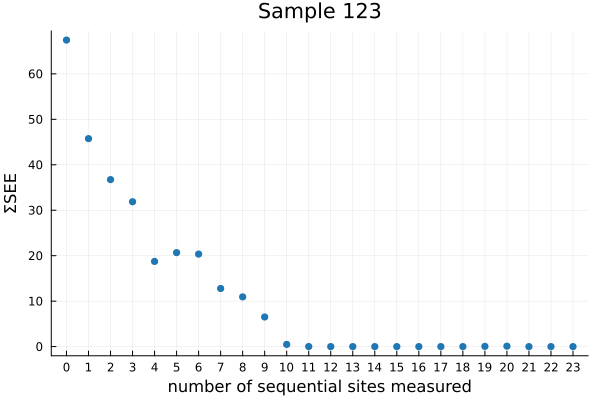

In [225]:
scatter(collect(0:23), vcat(sum_before, sums_seq_measure), label="", xlabel="number of sequential sites measured", 
    xticks=0:23, ylabel="ΣSEE", title="Sample $sample_idx", ms=4, msw=0,
    c=palette(:tab10)[1])

Heatmap visualisation where the y axis is the number of sites measured (starting at site 1) and the x-axis is the probe site (i.e., the site at which we compute the SEE)

In [234]:
measurement_mat = fill(NaN, 2, 3)

2×3 Matrix{Float64}:
 NaN  NaN  NaN
 NaN  NaN  NaN

In [715]:
mps_start = deepcopy(mps_80);
mps_start_opts = deepcopy(mps_80_opts)
ee_initial = entropy_von_neumann_see(mps_start);
measure_sites = [] # store the indices for the sites to measure, gradually build up
ts_instance = 123 # instance index in the test set
measurement_mat = fill(NaN, length(mps_start)+1, length(mps_start))
#measurement_mat[1, :] = ee_initial
for site in 0:(length(mps_start)-1)
    if site !== 0
        push!(measure_sites, site)
    end
    println("Measuring sites: $measure_sites")
    mps_measured = measure_mps_with_ts_sample(mps_start, X_test[ts_instance, :], mps_start_opts, measure_sites)
    remaining_site_entropies = entropy_von_neumann_see(mps_measured)
    measurement_mat[site+1, site+1:end] = remaining_site_entropies
end

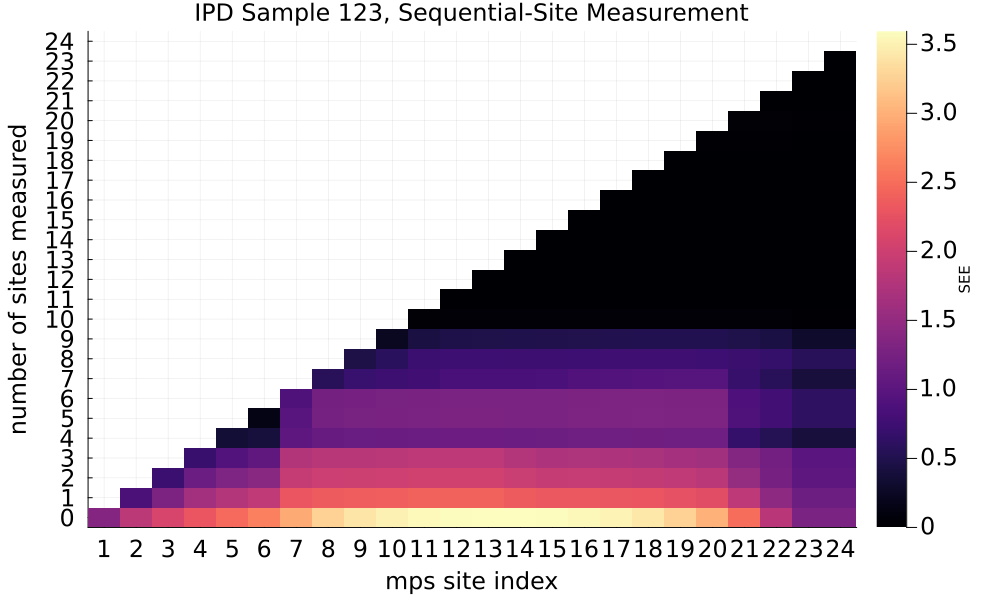

In [718]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), measurement_mat, 
    xticks=1:24, yticks=0:24, xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Sample $ts_instance, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))

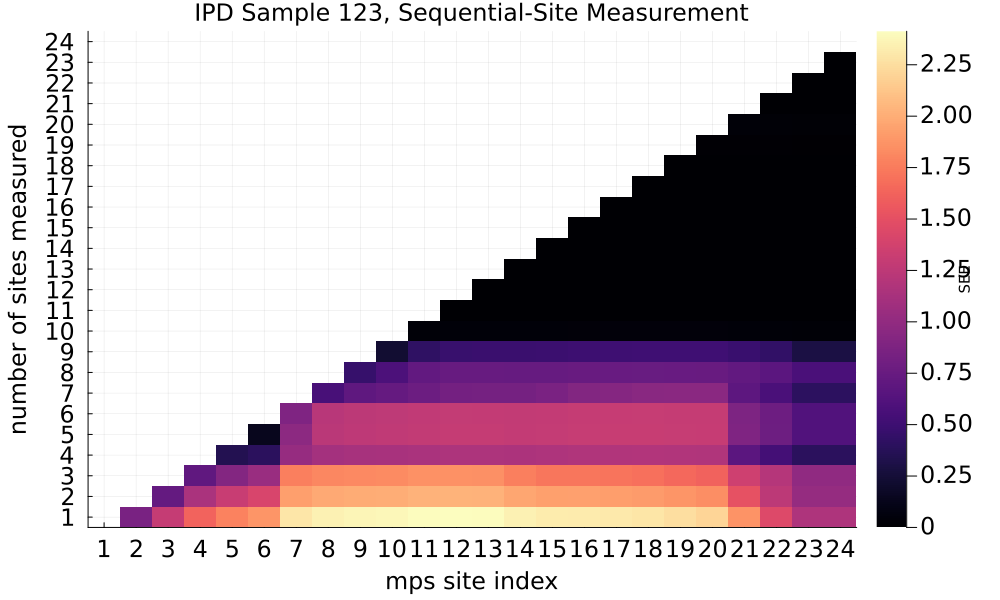

In [702]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(1:24), measurement_mat, 
    xticks=1:24, yticks=1:24, xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Sample $ts_instance, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))
#savefig("ipd_sequential_sample123.svg")

In [444]:
ipd123_1_24_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ipd_samp123_traj_1_24.jld2");
ipd123_1_24 = read(ipd123_1_24_f, "trajectories");
ipd123_11_24_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ipd_samp123_traj_11_24.jld2");
ipd123_11_24 = read(ipd123_11_24_f, "trajectories");
ipd123_15_24_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ipd_samp123_traj_15_24.jld2");
ipd123_15_24 = read(ipd123_15_24_f, "trajectories");
ipd123_5_24_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ipd_samp123_traj_5_24.jld2");
ipd123_5_24 = read(ipd123_5_24_f, "trajectories");
ipd123_3_24_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ipd_samp123_traj_3_24.jld2");
ipd123_3_24 = read(ipd123_3_24_f, "trajectories");

No conditioning pts

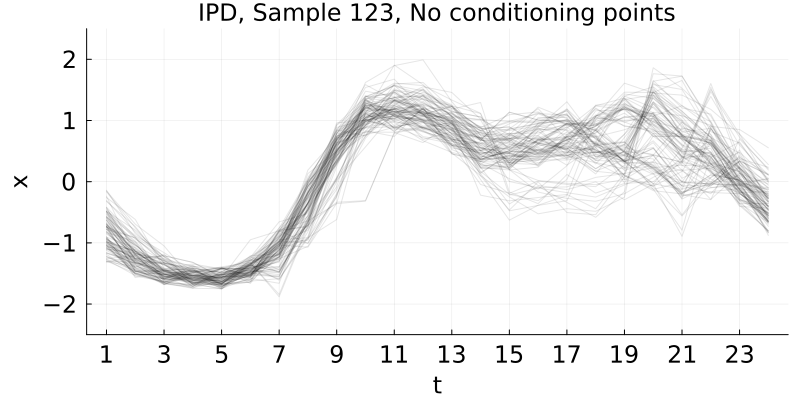

In [425]:
fstyle = font("sans-serif", 16)
p = plot(ipd123_1_24[1, :], label="", c=:black, alpha=0.1, lw=1, xlabel="t", 
    ylabel="x", xticks=1:2:24, title="IPD, Sample 123, No conditioning points",
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, titlefont=fstyle,
    size=(800, 400), left_margin=5mm, bottom_margin=5mm, ylims=(-2.5, 2.5))
Random.seed!(1)
for i in 1:100
    rand_idx = rand(1:size(ipd123_1_24, 1))
    p = plot!(ipd123_1_24[rand_idx, :], label="", c=:black, alpha=0.1, lw=1)
end
display(p)
#savefig("ipd_samp123_traj_no_cond.svg")

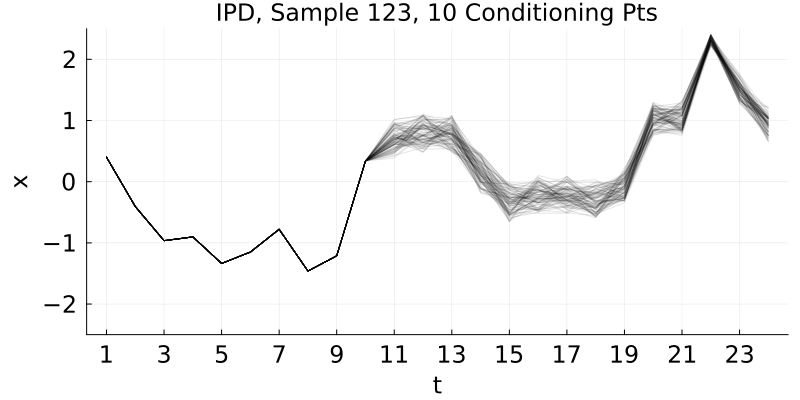

In [439]:
fstyle = font("sans-serif", 16)
p = plot(ipd123_11_24[1, :], label="", c=:black, alpha=0.1, lw=1, xlabel="t", 
    ylabel="x", xticks=1:2:24, title="IPD, Sample 123, 10 Conditioning Pts",
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, titlefont=fstyle,
    size=(800, 400), left_margin=5mm, bottom_margin=5mm, ylims=(-2.5, 2.5))
Random.seed!(1)
for i in 1:100
    rand_idx = rand(1:size(ipd123_11_24, 1))
    p = plot!(ipd123_11_24[rand_idx, :], label="", c=:black, alpha=0.1, lw=1)
end
display(p)
#savefig("ipd_samp123_traj_10_cond.svg")

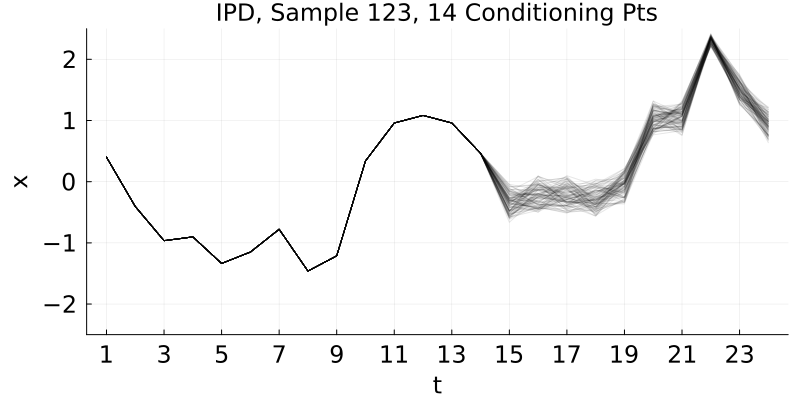

In [437]:
fstyle = font("sans-serif", 16)
p = plot(ipd123_15_24[1, :], label="", c=:black, alpha=0.1, lw=1, xlabel="t", 
    ylabel="x", xticks=1:2:24, title="IPD, Sample 123, 14 Conditioning Pts",
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, titlefont=fstyle,
    size=(800, 400), left_margin=5mm, bottom_margin=5mm, ylims=(-2.5, 2.5))
Random.seed!(1)
for i in 1:100
    rand_idx = rand(1:size(ipd123_15_24, 1))
    p = plot!(ipd123_15_24[rand_idx, :], label="", c=:black, alpha=0.1, lw=1)
end
display(p)
#savefig("ipd_samp123_traj_14_cond.svg")

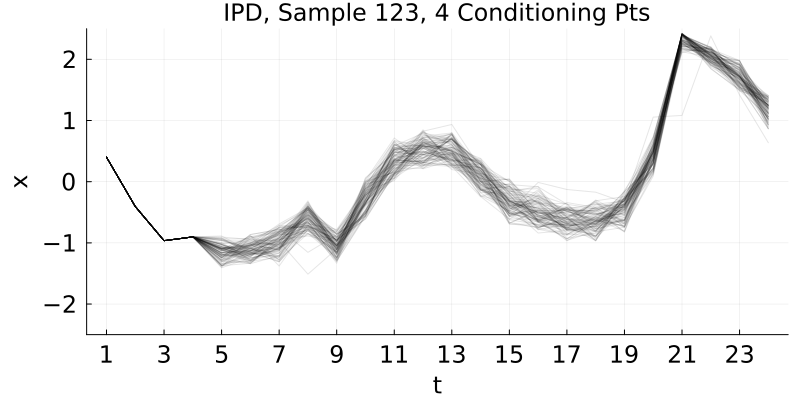

In [443]:
fstyle = font("sans-serif", 16)
p = plot(ipd123_5_24[1, :], label="", c=:black, alpha=0.1, lw=1, xlabel="t", 
    ylabel="x", xticks=1:2:24, title="IPD, Sample 123, 4 Conditioning Pts",
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, titlefont=fstyle,
    size=(800, 400), left_margin=5mm, bottom_margin=5mm, ylims=(-2.5, 2.5))
Random.seed!(1)
for i in 1:100
    rand_idx = rand(1:size(ipd123_5_24, 1))
    p = plot!(ipd123_5_24[rand_idx, :], label="", c=:black, alpha=0.1, lw=1)
end
display(p)
#savefig("ipd_samp123_traj_4_cond.svg")

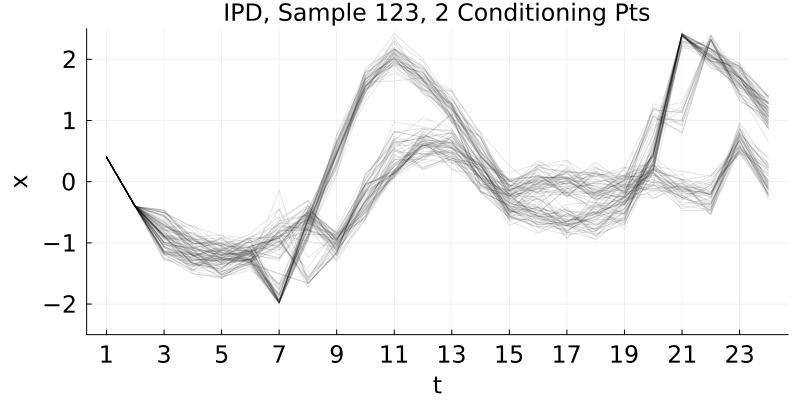

In [448]:
fstyle = font("sans-serif", 16)
p = plot(ipd123_3_24[1, :], label="", c=:black, alpha=0.1, lw=1, xlabel="t", 
    ylabel="x", xticks=1:2:24, title="IPD, Sample 123, 2 Conditioning Pts",
    xtickfont=fstyle, ytickfont=fstyle, guidefont=fstyle, titlefont=fstyle,
    size=(800, 400), left_margin=5mm, bottom_margin=5mm, ylims=(-2.5, 2.5))
Random.seed!(1)
for i in 1:100
    rand_idx = rand(1:size(ipd123_3_24, 1))
    p = plot!(ipd123_3_24[rand_idx, :], label="", c=:black, alpha=0.1, lw=1)
end
display(p)
#savefig("ipd_samp123_traj_2_cond.svg")

In [303]:
mps_start = deepcopy(mps_80);
mps_start_opts = deepcopy(mps_80_opts)
ee_initial = entropy_von_neumann_see(mps_start);
measure_sites = [] # store the indices for the sites to measure, gradually build up
ts_instance = 123 # instance index in the test set
measurement_mat = fill(NaN, length(mps_start), length(mps_start))
for site in 1:(length(mps_start)-1)
    push!(measure_sites, site)
    println("Measuring sites: $measure_sites")
    mps_measured = measure_mps_with_ts_sample(mps_start, X_test[ts_instance, :], mps_start_opts, measure_sites)
    remaining_site_entropies_after_measure = entropy_von_neumann_see(mps_measured)
    remaining_site_entropies_before_measure = ee_initial[site+1:end]
    # get the difference between the remaining site entropies before measuring n sites and after
    diff_remaining_site_entropies = remaining_site_entropies_after_measure - remaining_site_entropies_before_measure
    measurement_mat[site, site+1:end] = diff_remaining_site_entropies
end

Measuring sites: Any[1]
Measured site 1
Measuring sites: Any[1, 2]
Measured site 1
Measured site 2
Measuring sites: Any[1, 2, 3]
Measured site 1
Measured site 2
Measured site 3
Measuring sites: Any[1, 2, 3, 4]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measuring sites: Any[1, 2, 3, 4, 5]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measuring sites: Any[1, 2, 3, 4, 5, 6]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measuring sites: Any[1, 2, 3, 4, 5, 6, 7, 8, 9]
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Meas

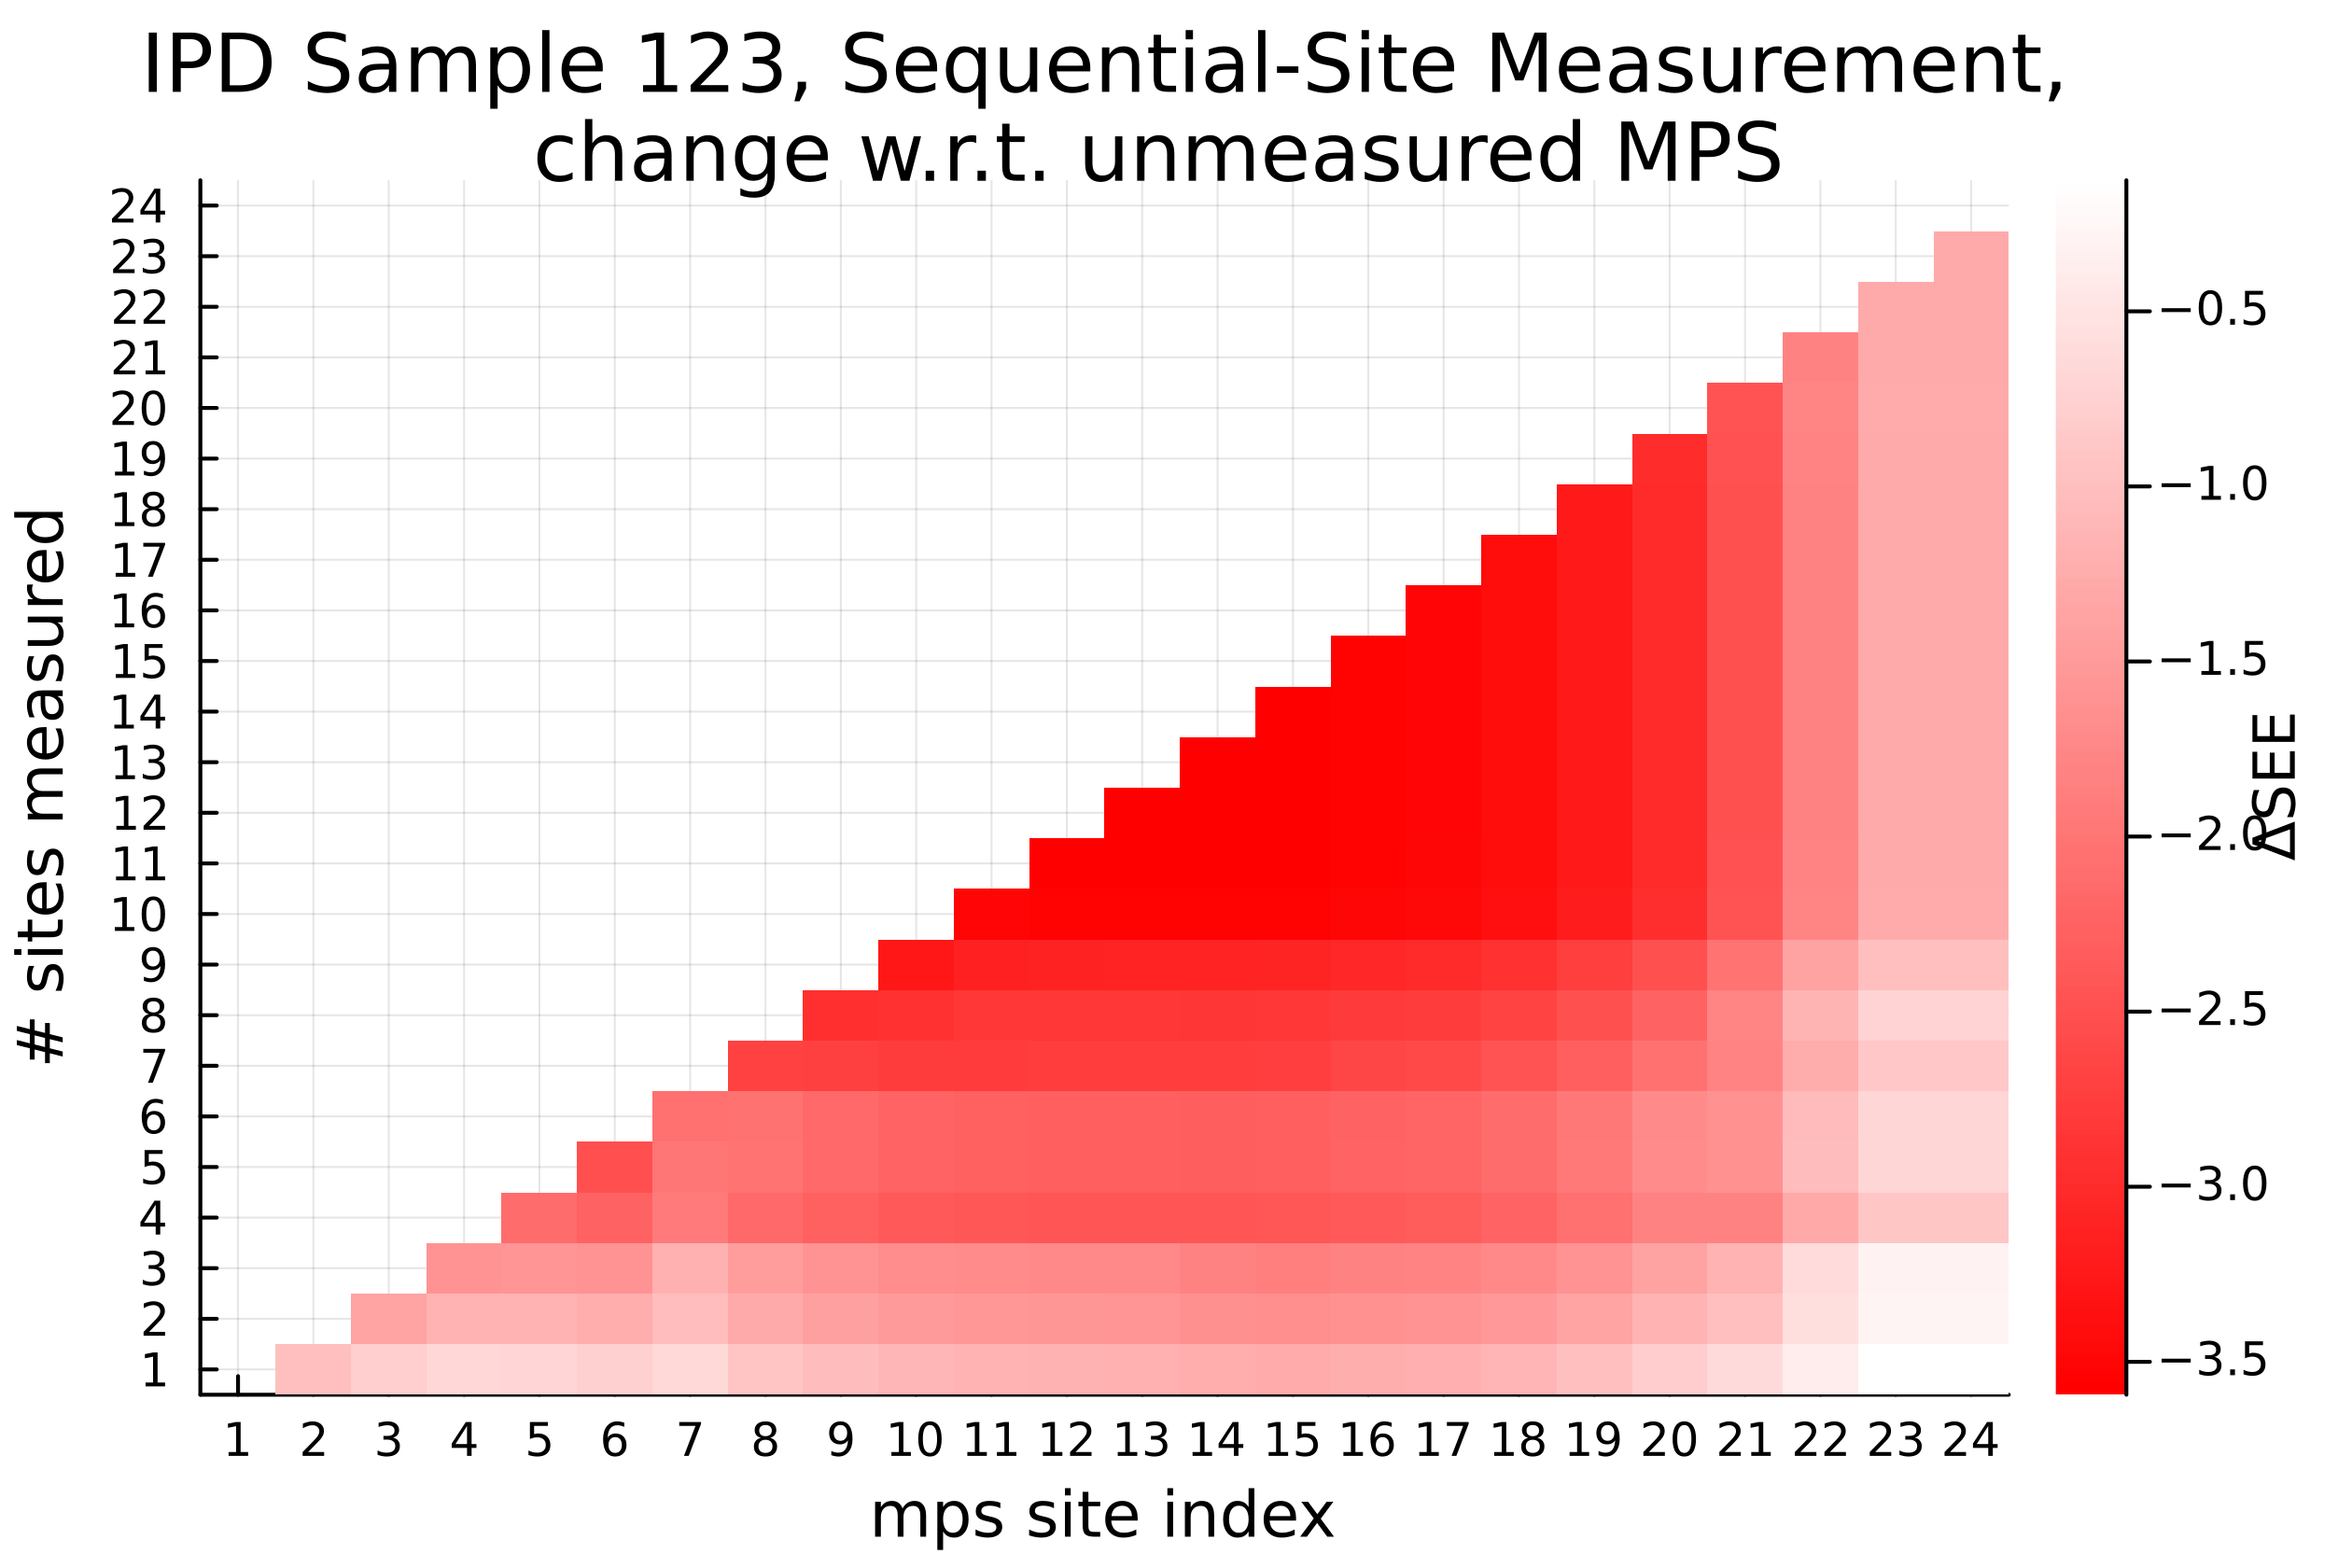

In [304]:
heatmap(collect(1:24), collect(1:24), measurement_mat, 
    xticks=1:24, yticks=1:24, xlabel="mps site index", ylabel="# sites measured",
    title="IPD Sample $ts_instance, Sequential-Site Measurement,
    change w.r.t. unmeasured MPS",
    colorbar_title="ΔSEE", c=cgrad([:white, :red], rev = true), dpi=420)
#savefig("ipd_sequential_sample123.png")

test-set averaged heatmap. There are two possibilities - we average over all test cases, and we average over classes

In [7]:
# loop over test instanes
mps_start = deepcopy(mps_80);
mps_start_opts = deepcopy(mps_80_opts)
ee_initial = entropy_von_neumann_see(mps_start);
measurement_mat_all_test = fill(NaN, size(X_test, 1), length(mps_start)+1, length(mps_start)) # first dimension is test instance

@showprogress for ts_instance in 1:size(X_test, 1)
    println("Evaluating instance $ts_instance")
    measure_sites = [] # store the indices for the sites to measure, gradually build up
    measurement_mat = fill(NaN, length(mps_start)+1, length(mps_start))
    for site in 0:(length(mps_start)-1)
        if site !== 0 # get initial ee for unmeasured mps as well
            push!(measure_sites, site)
        end
        #println("Measuring sites: $measure_sites")
        mps_measured = measure_mps_with_ts_sample(mps_start, X_test[ts_instance, :], mps_start_opts, measure_sites)
        remaining_site_entropies = entropy_von_neumann_see(mps_measured)
        measurement_mat[(site+1), site+1:end] = remaining_site_entropies
    end
    measurement_mat_all_test[ts_instance, :, :] = measurement_mat
end

Evaluating instance 1
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
M

Progress:   0%|▏                                        |  ETA: 1:35:35

Evaluating instance 3
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
M

Progress:   0%|▏                                        |  ETA: 1:17:40

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:   0%|▏                                        |  ETA: 1:06:32

Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 5
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 

Progress:   0%|▎                                        |  ETA: 1:03:12

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   1%|▎                                        |  ETA: 1:02:11

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   1%|▎                                        |  ETA: 0:59:09

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   1%|▍                                        |  ETA: 0:56:37

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   1%|▍                                        |  ETA: 0:54:13

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   1%|▍                                        |  ETA: 0:52:41

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:   1%|▌                                        |  ETA: 0:52:46

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   1%|▌                                        |  ETA: 0:51:57

Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 13
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Mea

Progress:   1%|▌                                        |  ETA: 0:51:16

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   1%|▌                                        |  ETA: 0:51:01

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   1%|▋                                        |  ETA: 0:50:45

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   2%|▋                                        |  ETA: 0:50:27

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   2%|▋                                        |  ETA: 0:50:04

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   2%|▊                                        |  ETA: 0:49:15

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   2%|▊                                        |  ETA: 0:48:18

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   2%|▊                                        |  ETA: 0:47:49

Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measure

Progress:   2%|▉                                        |  ETA: 0:47:25

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   2%|▉                                        |  ETA: 0:47:14

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   2%|▉                                        |  ETA: 0:47:03

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   2%|█                                        |  ETA: 0:47:01

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:   2%|█                                        |  ETA: 0:47:01

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   3%|█                                        |  ETA: 0:46:57

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured s

Progress:   3%|█▏                                       |  ETA: 0:47:01

Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measure

Progress:   3%|█▏                                       |  ETA: 0:47:17

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measure

Progress:   3%|█▏                                       |  ETA: 0:47:16

Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 30
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured 

Progress:   3%|█▎                                       |  ETA: 0:47:29

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   3%|█▎                                       |  ETA: 0:47:18

Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 32
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Mea

Progress:   3%|█▎                                       |  ETA: 0:47:55

Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Meas

Progress:   3%|█▍                                       |  ETA: 0:47:47

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   3%|█▍                                       |  ETA: 0:47:22

Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 35
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured 

Progress:   3%|█▍                                       |  ETA: 0:46:57

Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 36
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured sit

Progress:   3%|█▍                                       |  ETA: 0:46:31

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measure

Progress:   4%|█▌                                       |  ETA: 0:46:09

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   4%|█▌                                       |  ETA: 0:45:49

Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 39
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Meas

Progress:   4%|█▌                                       |  ETA: 0:45:51

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   4%|█▋                                       |  ETA: 0:45:35

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measure

Progress:   4%|█▋                                       |  ETA: 0:45:21

Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 42
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 1
Measured site 2
Measured site 3
Measu

Progress:   4%|█▋                                       |  ETA: 0:45:08

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured s

Progress:   4%|█▊                                       |  ETA: 0:44:43

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measure

Progress:   4%|█▊                                       |  ETA: 0:44:24

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   4%|█▊                                       |  ETA: 0:44:05

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   4%|█▉                                       |  ETA: 0:43:45

Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 47
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measur

Progress:   5%|█▉                                       |  ETA: 0:43:28

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:   5%|█▉                                       |  ETA: 0:43:17

Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 49
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured 

Progress:   5%|██                                       |  ETA: 0:43:09

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   5%|██                                       |  ETA: 0:42:51

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site

Progress:   5%|██                                       |  ETA: 0:42:46

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured s

Progress:   5%|██▏                                      |  ETA: 0:42:46

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 53
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Mea

Progress:   5%|██▏                                      |  ETA: 0:42:49

Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measure

Progress:   5%|██▏                                      |  ETA: 0:42:39

Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 55
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Mea

Progress:   5%|██▎                                      |  ETA: 0:42:42

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measure

Progress:   5%|██▎                                      |  ETA: 0:42:34

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   6%|██▎                                      |  ETA: 0:42:28

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   6%|██▎                                      |  ETA: 0:42:15

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:   6%|██▍                                      |  ETA: 0:42:15

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   6%|██▍                                      |  ETA: 0:42:12

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   6%|██▍                                      |  ETA: 0:42:12

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   6%|██▌                                      |  ETA: 0:42:08

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   6%|██▌                                      |  ETA: 0:42:02

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   6%|██▌                                      |  ETA: 0:41:58

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   6%|██▋                                      |  ETA: 0:42:00

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   6%|██▋                                      |  ETA: 0:41:46

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   7%|██▋                                      |  ETA: 0:41:38

Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 68
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured 

Progress:   7%|██▊                                      |  ETA: 0:41:39

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   7%|██▊                                      |  ETA: 0:41:38

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   7%|██▊                                      |  ETA: 0:41:28

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   7%|██▉                                      |  ETA: 0:41:18

Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measure

Progress:   7%|██▉                                      |  ETA: 0:41:09

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   7%|██▉                                      |  ETA: 0:40:58

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   7%|███                                      |  ETA: 0:40:52

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:   7%|███                                      |  ETA: 0:40:42

Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 76
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured si

Progress:   7%|███                                      |  ETA: 0:40:42

Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 77
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured sit

Progress:   7%|███▏                                     |  ETA: 0:40:43

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   8%|███▏                                     |  ETA: 0:40:35

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:   8%|███▏                                     |  ETA: 0:40:32

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   8%|███▎                                     |  ETA: 0:40:24

Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 81
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measur

Progress:   8%|███▎                                     |  ETA: 0:40:16

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   8%|███▎                                     |  ETA: 0:40:10

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured s

Progress:   8%|███▎                                     |  ETA: 0:40:07

Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Meas

Progress:   8%|███▍                                     |  ETA: 0:40:01

Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measure

Progress:   8%|███▍                                     |  ETA: 0:40:13

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:   8%|███▍                                     |  ETA: 0:40:12

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Progress:   8%|███▌                                     |  ETA: 0:40:08

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   9%|███▌                                     |  ETA: 0:40:04

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   9%|███▌                                     |  ETA: 0:39:54

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   9%|███▋                                     |  ETA: 0:39:47

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:   9%|███▋                                     |  ETA: 0:39:39

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   9%|███▋                                     |  ETA: 0:39:31

Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 93
Measured site 1
Measured site 1
Measured site 2
Measured sit

Progress:   9%|███▊                                     |  ETA: 0:39:27

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measur

Progress:   9%|███▊                                     |  ETA: 0:39:35

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 95
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measur

Progress:   9%|███▊                                     |  ETA: 0:39:33

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:   9%|███▉                                     |  ETA: 0:39:38

Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 97
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Mea

Progress:   9%|███▉                                     |  ETA: 0:39:39

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site

Progress:  10%|███▉                                     |  ETA: 0:39:45

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:  10%|████                                     |  ETA: 0:39:39

Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 100
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measu

Progress:  10%|████                                     |  ETA: 0:39:36

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:  10%|████                                     |  ETA: 0:39:36

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measur

Progress:  10%|████▏                                    |  ETA: 0:39:32

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site

Progress:  10%|████▏                                    |  ETA: 0:39:34

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measure

Progress:  10%|████▏                                    |  ETA: 0:39:41

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measure

Progress:  10%|████▏                                    |  ETA: 0:39:45

Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measu

Progress:  10%|████▎                                    |  ETA: 0:39:49

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

Progress:  10%|████▎                                    |  ETA: 0:39:52

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured s

Progress:  10%|████▎                                    |  ETA: 0:39:50

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measure

Progress:  11%|████▍                                    |  ETA: 0:39:51

Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured

Progress:  11%|████▍                                    |  ETA: 0:39:56

Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 111
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measu

Progress:  11%|████▍                                    |  ETA: 0:39:57

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 22
Measured site 23
Evaluating instance 112
Measured site 1
Measured site 1
Measured site 2
Measured site 1
Measured site 2
Measured site 3
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 1
Measured site 2
Me

Progress:  11%|████▌                                    |  ETA: 0:39:57

Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured s

Excessive output truncated after 524292 bytes.

Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 1
Measured site 2
Measured site 3
Measured site 4
Measured site 5
Measured site 6
Measured site 7
Measured site 8
Measured site 9
Measured site 10
Measured site 11
Measured site 12
Measured site 13
Measured site 14
Measured site 15
Measured site 16
Measured site 17
Measured site 18
Measured site 19
Measured site 20
Measured site 21
Measured site 1
Measure

In [8]:
size(measurement_mat_all_test)

(1029, 25, 24)

In [9]:
# average over all test instances
test_set_mean_measure_matrix = fill(NaN, length(mps_start)+1, length(mps_start))
test_set_median_measure_matrix = fill(NaN, length(mps_start)+1, length(mps_start))
test_set_std_measure_matrix = fill(NaN, length(mps_start)+1, length(mps_start))
for i in 0:(length(mps_start)+1)
    for j in (i+1):length(mps_start)
        test_set_mean_measure_matrix[i+1, j] = mean(measurement_mat_all_test[:, i+1, j])
        test_set_std_measure_matrix[i+1, j] = std(measurement_mat_all_test[:, i+1, j])
        test_set_median_measure_matrix[i+1, j] = median(measurement_mat_all_test[:, i+1, j])
    end
end

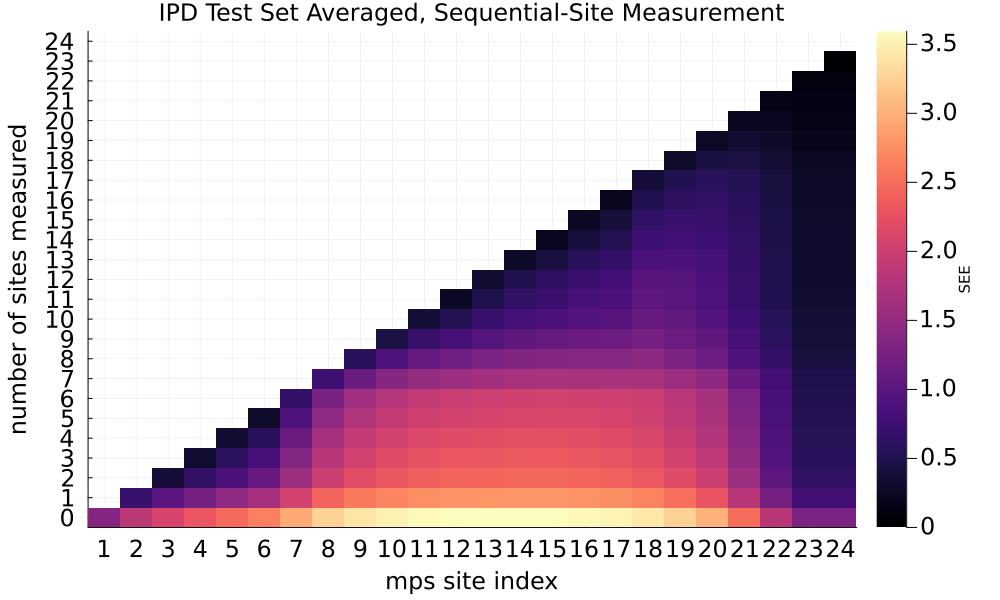

In [12]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), test_set_mean_measure_matrix, xticks=1:24, yticks=0:24, 
xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Test Set Averaged, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))
#savefig("ipd_sequential_testset_avg.svg")

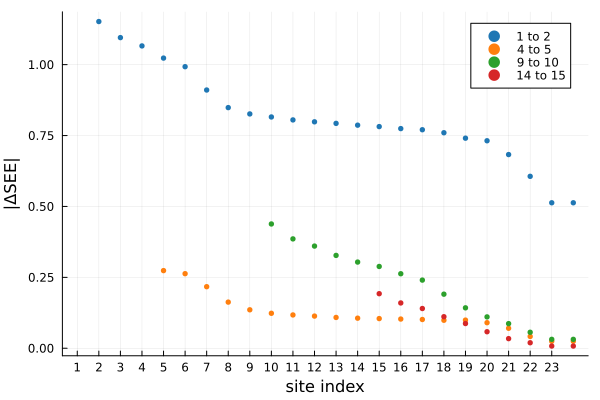

In [744]:
diffs_2_1 = test_set_mean_measure_matrix[2, 1:end] - test_set_mean_measure_matrix[1, 1:end]
diffs_5_4 = test_set_mean_measure_matrix[5, 1:end] - test_set_mean_measure_matrix[4, 1:end]
diffs_10_9 = test_set_mean_measure_matrix[10, 1:end] - test_set_mean_measure_matrix[9, 1:end]
diffs_15_14 = test_set_mean_measure_matrix[15, 1:end] - test_set_mean_measure_matrix[14, 1:end]
scatter(abs.(diffs_2_1), label="1 to 2", xticks=1:1:23, xlabel="site index", ylabel="|ΔSEE|", msw=0, 
    ms=3, c=palette(:tab10)[1])
scatter!(abs.(diffs_5_4), label="4 to 5", xticks=1:1:23, xlabel="site index", ylabel="|ΔSEE|", msw=0, 
    ms=3, c=palette(:tab10)[2])
scatter!(abs.(diffs_10_9), label="9 to 10", xticks=1:1:23, xlabel="site index", ylabel="|ΔSEE|", msw=0, 
    ms=3, c=palette(:tab10)[3])
scatter!(abs.(diffs_15_14), label="14 to 15", xticks=1:1:23, xlabel="site index", ylabel="|ΔSEE|", msw=0, 
    ms=3, c=palette(:tab10)[4])

residual entanglement as the sum of the SEE of the unmeasured sites

In [15]:
mean_residual_entanglement = []
for i in 0:24
    row_sum = sum(test_set_mean_measure_matrix[i+1, (i+1):end])
    push!(mean_residual_entanglement, row_sum)
end

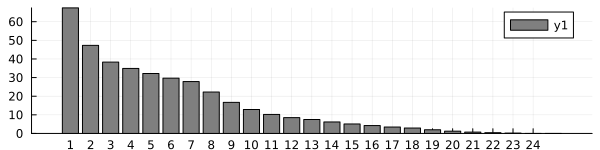

In [70]:
pbar = bar(mean_residual_entanglement, xticks=1:24,
    c = palette(:tab10)[8])
plot(pbar, layout=@layout([a b]), size=(600, 150),
    margin=0mm)
#savefig("ipd_resiudal_entanglement_barplot.svg")

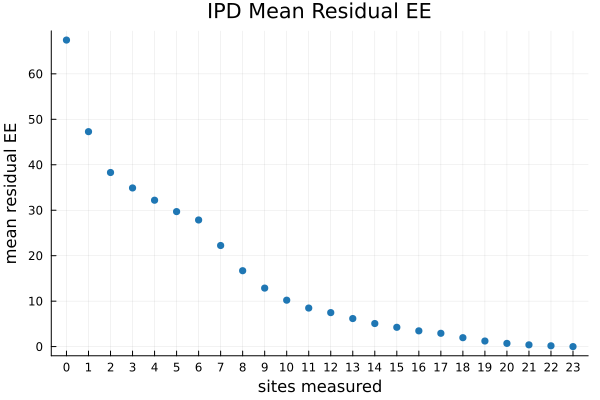

In [16]:
scatter(collect(0:23), mean_residual_entanglement, xticks=0:1:23,
    label="", ms=4, msw=0, c=palette(:tab10)[1],
    xlabel="sites measured", ylabel="mean residual EE",
    title="IPD Mean Residual EE")
#savefig("ipd_mean_residual_ee.svg")

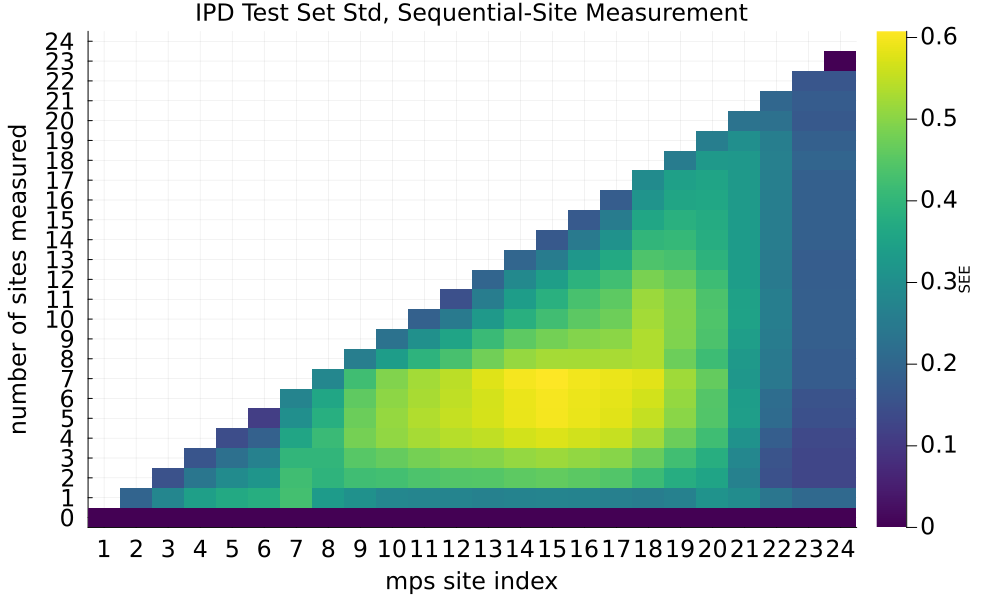

In [765]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), test_set_std_measure_matrix, xticks=1:24, yticks=0:24,  
xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Test Set Std, Sequential-Site Measurement",
    colorbar_title="SEE", c=:viridis, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))
#savefig("ipd_sequential_testset_std.svg")

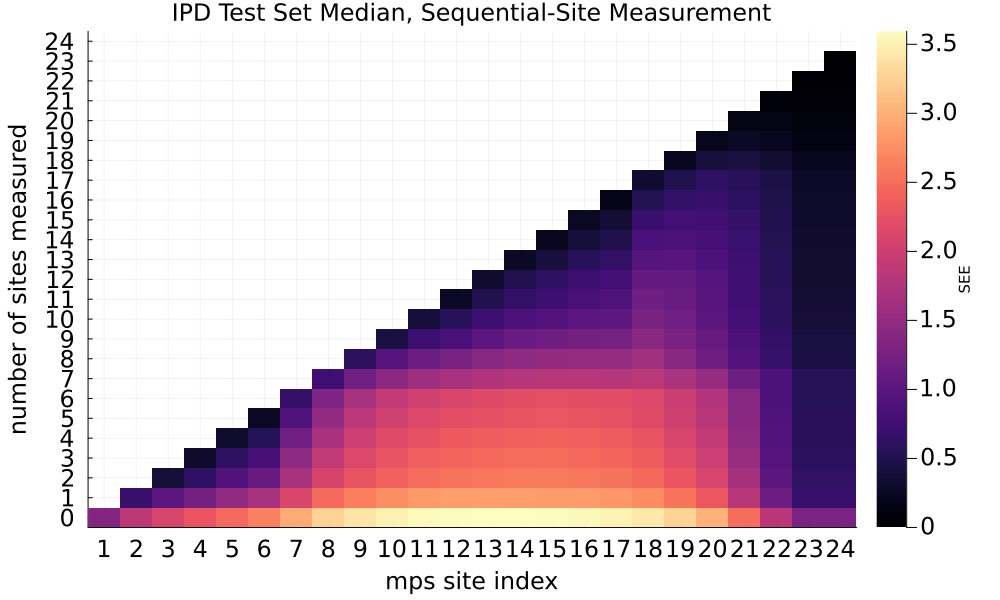

In [769]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), test_set_median_measure_matrix, xticks=1:24, yticks=0:24, 
xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Test Set Median, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))
#savefig("ipd_sequential_testset_median.svg")

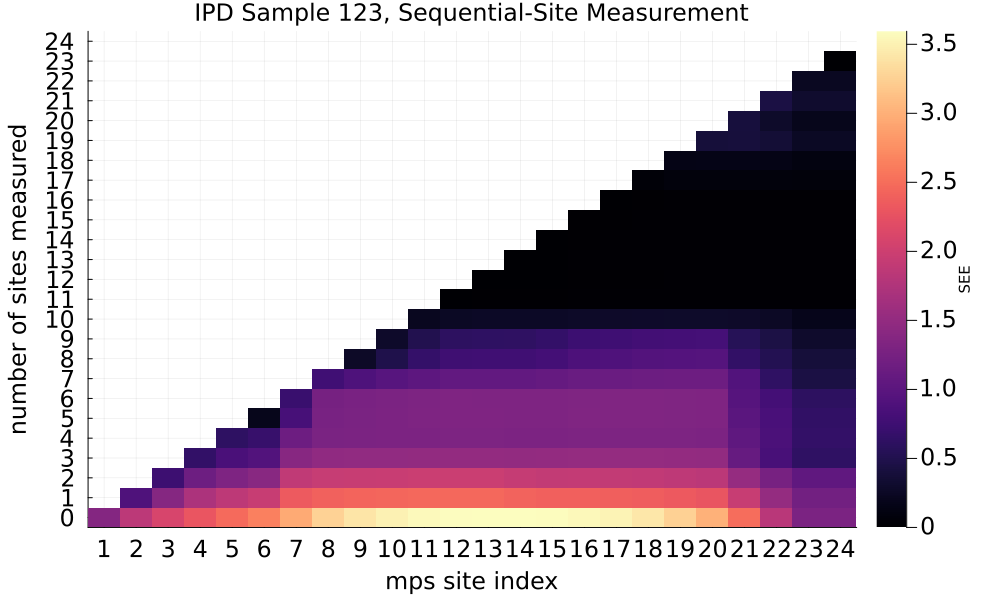

In [780]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:24), collect(0:24), measurement_mat_all_test[1, :, :], xticks=1:24, yticks=0:24, 
xlabel="mps site index", ylabel="number of sites measured",
    title="IPD Sample 123, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))
#savefig("ipd_sequential_sample123.svg")

---

# ECG200

In [472]:
ecg_mps_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/ecg_d_12_chi_80.jld2")
ecg_mps = read(ecg_mps_f, "mps")
ecg_opts = read(ecg_mps_f, "opts_safe");
ecg_data_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/Data/ecg200/datasets/ecg200.jld2")
X_train_ecg_loaded = read(ecg_data_f, "X_train");
X_test_ecg_loaded = read(ecg_data_f, "X_test");
X_train_ecg, norms = transform_train_data(X_train_ecg_loaded; opts=ecg_opts);
X_test_ecg, _ = transform_test_data(X_test_ecg_loaded, norms; opts=ecg_opts);

┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.05051431347958382
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253
┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.058283139456711236
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253


5 rescaling operations were performed!


┌ Warning: Test set has a value more than 1% below lower bound after train normalization! lb=-0.04947715552359307
└ @ Main /Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/LogLoss/utils.jl:253


In [482]:
mps_start_ecg = deepcopy(ecg_mps);
mps_start_ecg_opts = deepcopy(ecg_opts)
ee_initial_ecg = entropy_von_neumann_see(mps_start_ecg);
measure_sites = [] # store the indices for the sites to measure, gradually build up
ts_instance = 45 # instance index in the test set
measurement_mat = fill(NaN, length(mps_start_ecg), length(mps_start_ecg))
for site in 1:(length(mps_start_ecg)-1)
    push!(measure_sites, site)
    #println("Measuring sites: $measure_sites");
    mps_measured = measure_mps_with_ts_sample(mps_start_ecg, X_test_ecg[ts_instance, :], mps_start_ecg_opts, measure_sites)
    remaining_site_entropies = entropy_von_neumann_see(mps_measured)
    measurement_mat[site, site+1:end] = remaining_site_entropies
end

In [804]:
# loop over test instanes
mps_start_ecg = deepcopy(ecg_mps);
mps_start_ecg_opts = deepcopy(ecg_opts)
ee_initial_ecg = entropy_von_neumann_see(mps_start_ecg);
measurement_mat_all_test = fill(NaN, size(X_test_ecg, 1), length(mps_start_ecg)+1, length(mps_start_ecg)) # first dimension is test instance

@showprogress for ts_instance in 1:size(X_test_ecg, 1)
    println("Evaluating instance $ts_instance")
    measure_sites = [] # store the indices for the sites to measure, gradually build up
    measurement_mat = fill(NaN, length(mps_start_ecg)+1, length(mps_start_ecg))
    for site in 0:(length(mps_start_ecg)-1)
        if site !== 0 # get initial ee for unmeasured mps as well
            push!(measure_sites, site)
        end
        #println("Measuring sites: $measure_sites")
        mps_measured = measure_mps_with_ts_sample(mps_start_ecg, X_test_ecg[ts_instance, :], mps_start_ecg_opts, measure_sites)
        remaining_site_entropies = entropy_von_neumann_see(mps_measured)
        measurement_mat[(site+1), site+1:end] = remaining_site_entropies
    end
    measurement_mat_all_test[ts_instance, :, :] = measurement_mat
end

In [806]:
# average over all test instances
test_set_mean_measure_matrix = fill(NaN, length(mps_start_ecg)+1, length(mps_start_ecg))
test_set_median_measure_matrix = fill(NaN, length(mps_start_ecg)+1, length(mps_start_ecg))
test_set_std_measure_matrix = fill(NaN, length(mps_start_ecg)+1, length(mps_start_ecg))
for i in 0:(length(mps_start_ecg)+1)
    for j in (i+1):length(mps_start_ecg)
        test_set_mean_measure_matrix[i+1, j] = mean(measurement_mat_all_test[:, i+1, j])
        test_set_std_measure_matrix[i+1, j] = std(measurement_mat_all_test[:, i+1, j])
        test_set_median_measure_matrix[i+1, j] = median(measurement_mat_all_test[:, i+1, j])
    end
end

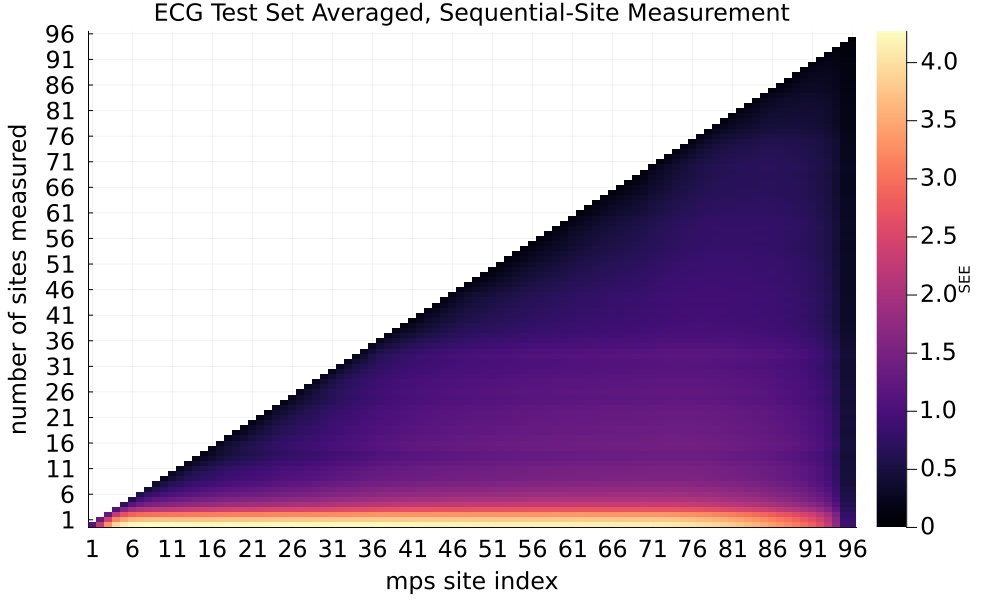

In [809]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:96), collect(0:96), test_set_mean_measure_matrix, xticks=1:5:96, yticks=1:5:96, 
xlabel="mps site index", ylabel="number of sites measured",
    title="ECG Test Set Averaged, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))
#savefig("ecg_sequential_testset_avg.svg")

In [810]:
mean_residual_entanglement = []
for i in 0:96
    row_sum = sum(test_set_mean_measure_matrix[i+1, (i+1):end])
    push!(mean_residual_entanglement, row_sum)
end

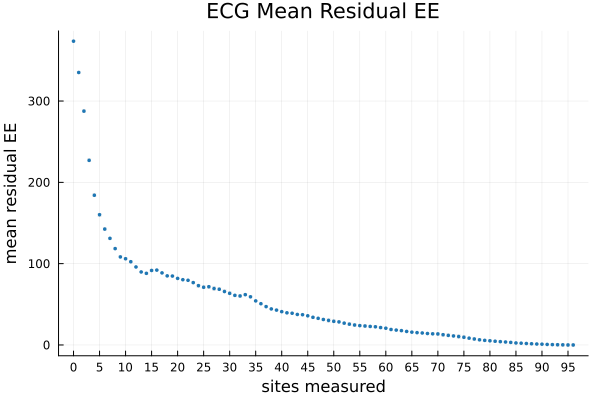

In [814]:
scatter(collect(0:96), mean_residual_entanglement, xticks=0:5:96, yerr=errors,
    label="", ms=2, msw=0, c=palette(:tab10)[1],
    xlabel="sites measured", ylabel="mean residual EE",
    title="ECG Mean Residual EE")
#savefig("ecg_mean_residual_ee.svg")

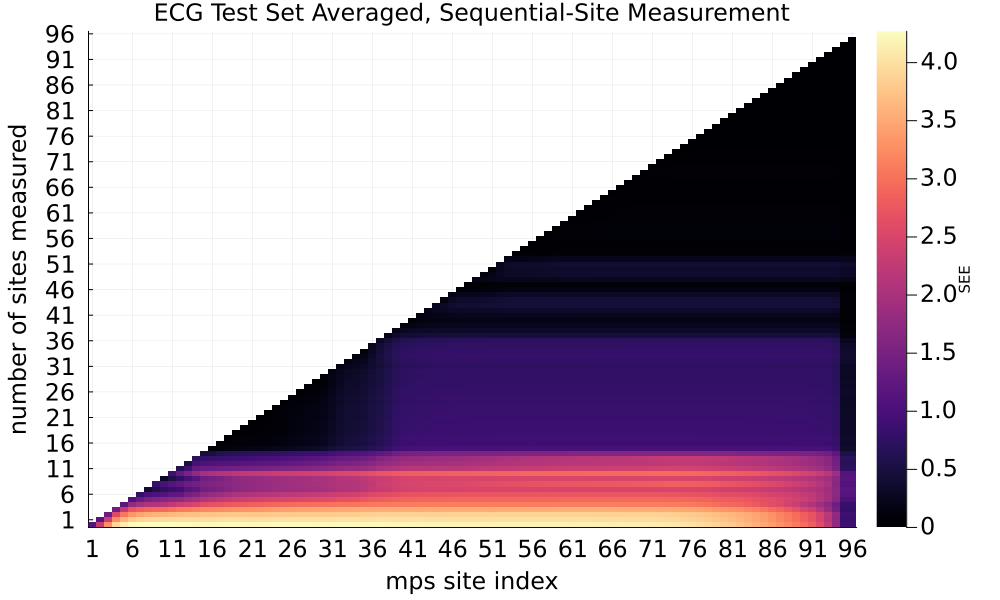

In [822]:
fstyle = font("sans-serif", 16) #4
heatmap(collect(1:96), collect(0:96), measurement_mat_all_test[5, :, :], xticks=1:5:96, yticks=1:5:96, 
xlabel="mps site index", ylabel="number of sites measured",
    title="ECG Test Set Averaged, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm, 
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))

In [7]:
nts_mps_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/nts_simple_mps.jld2");
nts_mps = read(nts_mps_f, "mps");
nts_opts = read(nts_mps_f, "opts");
nts_data_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/Data/syntheticV2/simple/datasets/eta_01_m_3_tau_20.jld2");
X_train_nts_loaded = read(nts_data_f, "X_train");
X_test_nts_loaded = read(nts_data_f, "X_test");
X_train_nts, norms = transform_train_data(X_train_nts_loaded; opts=nts_opts);
X_test_nts, _ = transform_test_data(X_test_nts_loaded, norms; opts=nts_opts);

1 rescaling operations were performed!


In [9]:
# loop over test instanes
mps_start_nts = deepcopy(nts_mps);
mps_start_nts_opts = deepcopy(nts_opts)
ee_initial_nts = entropy_von_neumann_see(mps_start_nts);
measurement_mat_all_test = fill(NaN, size(X_test_nts, 1), length(mps_start_nts)+1, length(mps_start_nts)) # first dimension is test instance

for ts_instance in 1:1
    println("Evaluating instance $ts_instance")
    measure_sites = [] # store the indices for the sites to measure, gradually build up
    measurement_mat = fill(NaN, length(mps_start_nts)+1, length(mps_start_nts))
    for site in 0:(length(mps_start_nts)-1)
        if site !== 0 # get initial ee for unmeasured mps as well
            push!(measure_sites, site)
        end
        #println("M easuring sites: $measure_sites")
        mps_measured = measure_mps_with_ts_sample(mps_start_nts, X_test_nts[ts_instance, :], mps_start_nts_opts, measure_sites)
        remaining_site_entropies = entropy_von_neumann_see(mps_measured)
        measurement_mat[(site+1), site+1:end] = remaining_site_entropies
    end
    measurement_mat_all_test[ts_instance, :, :] = measurement_mat
end

In [17]:
# average over all test instances
test_set_mean_measure_matrix = fill(NaN, length(mps_start_nts)+1, length(mps_start_nts))
test_set_median_measure_matrix = fill(NaN, length(mps_start_nts)+1, length(mps_start_nts))
test_set_std_measure_matrix = fill(NaN, length(mps_start_nts)+1, length(mps_start_nts))
for i in 0:(length(mps_start_nts)+1)
    for j in (i+1):length(mps_start_nts)
        test_set_mean_measure_matrix[i+1, j] = mean(measurement_mat_all_test[1, i+1, j])
        test_set_std_measure_matrix[i+1, j] = std(measurement_mat_all_test[1, i+1, j])
        test_set_median_measure_matrix[i+1, j] = median(measurement_mat_all_test[1, i+1, j])
    end
end

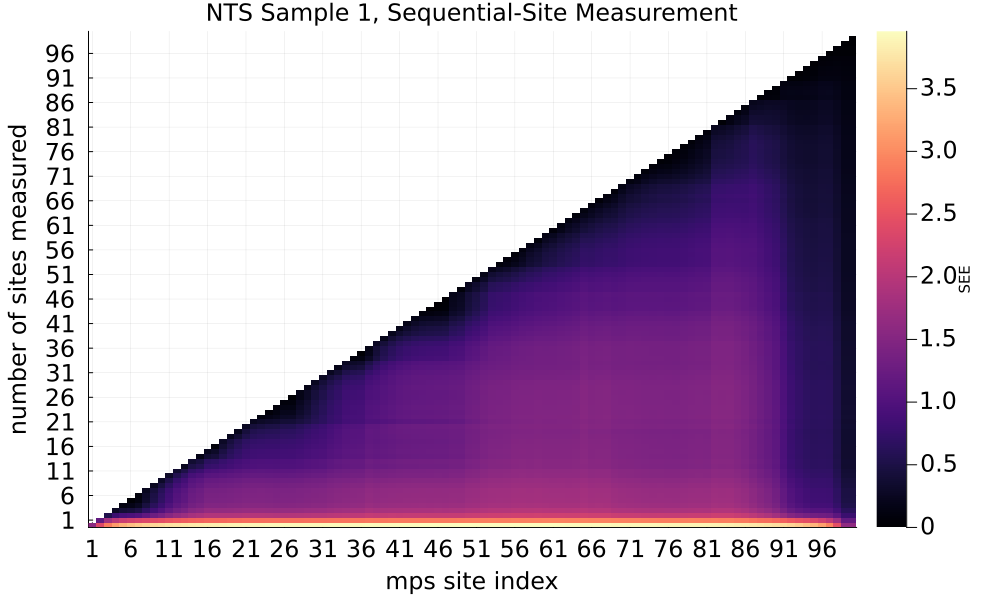

In [33]:
fstyle = font("sans-serif", 16)
heatmap(collect(1:100), collect(0:100), measurement_mat_all_test[1, :, :], xticks=1:5:100, yticks=1:5:100, 
xlabel="mps site index", ylabel="number of sites measured",
    title="NTS Sample 1, Sequential-Site Measurement",
    colorbar_title="SEE", c=:magma, left_margin=5mm,
    bottom_margin=5mm, right_margin=5mm, 
    xtickfont=fstyle, 
    titlefont=fstyle,
    guidefont=fstyle,
    ytickfont=fstyle, size=(1000, 600))

In [18]:
mean_residual_entanglement = []
for i in 0:100
    row_sum = sum(test_set_mean_measure_matrix[i+1, (i+1):end])
    push!(mean_residual_entanglement, row_sum)
end

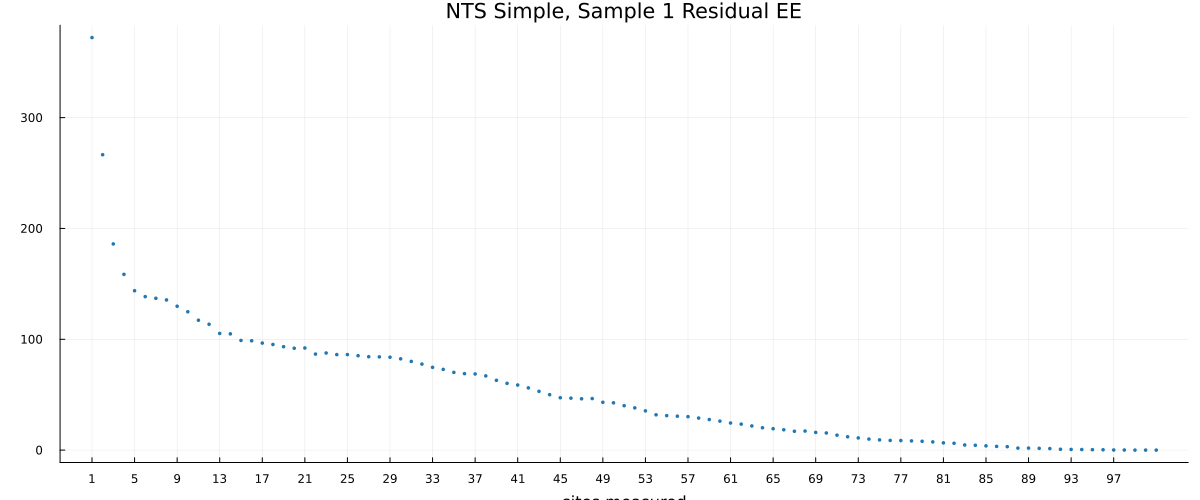

In [164]:
scatter(mean_residual_entanglement, xticks=1:4:100, ms=2, label="", msw=0,
    title="NTS Simple, Sample 1 Residual EE",  xlabel="sites measured", ylabel="mean residual EE", 
    c=palette(:tab10)[1], size=(1200, 500))
#savefig("nts_sample1_residual_ee.svg")

In [165]:
nts_traj_1_100_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/nts_simple_traj_1_100.jld2")
nts_traj_1_100 = read(nts_traj_1_100_f, "trajectories");
nts_traj_2_100_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/nts_simple_traj_2_100.jld2")
nts_traj_2_100 = read(nts_traj_2_100_f, "trajectories");
nts_traj_4_100_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/nts_simple_traj_4_100.jld2")
nts_traj_4_100 = read(nts_traj_4_100_f, "trajectories");
nts_traj_16_100_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/nts_simple_traj_16_100.jld2")
nts_traj_16_100 = read(nts_traj_16_100_f, "trajectories");
nts_traj_61_100_f = jldopen("/Users/joshua/Desktop/QuantumInspiredMLFinal/QuantumInspiredML/nts_simple_traj_61_100.jld2")
nts_traj_61_100 = read(nts_traj_61_100_f, "trajectories");

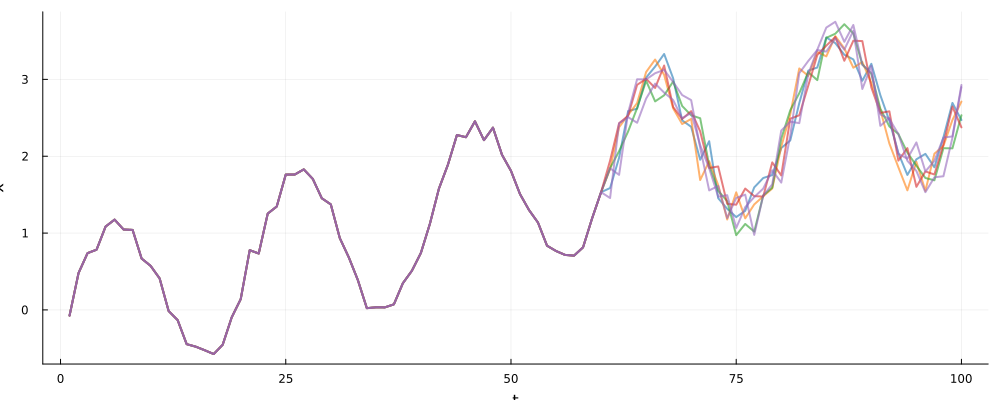

In [168]:
#p = plot(collect(4:100), X_test_nts_loaded[1, 4:100], label="", lw=3, c=:black)
p = plot(nts_traj_61_100[1, :], label="", c=palette(:tab10)[1], alpha=0.6, xlabel="t", ylabel="x",
    size=(1000, 400), lw=2)
plot!(nts_traj_61_100[87, :], label="", c=palette(:tab10)[2], alpha=0.6, lw=2)
plot!(nts_traj_61_100[11, :], label="", c=palette(:tab10)[3], alpha=0.6, lw=2)
plot!(nts_traj_61_100[24, :], label="", c=palette(:tab10)[4], alpha=0.6, lw=2)
plot!(nts_traj_61_100[33, :], label="", c=palette(:tab10)[5], alpha=0.6, lw=2)
plot!(nts_traj_61_100[83, :], label="", c=palette(:tab10)[5], alpha=0.6, lw=2)
#savefig("nts_traj_61_100.svg")

In [86]:
make_kde_heatmap(nts_traj_1_100, 1:100, 10)

UndefVarError: UndefVarError: `make_kde_heatmap` not defined in `Main`
Suggestion: check for spelling errors or missing imports.